In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
import pickle as pkl
from datasets.dataset import *
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['figure.figsize'] = [15, 15]

In [3]:
i = 13

Current frame:  18


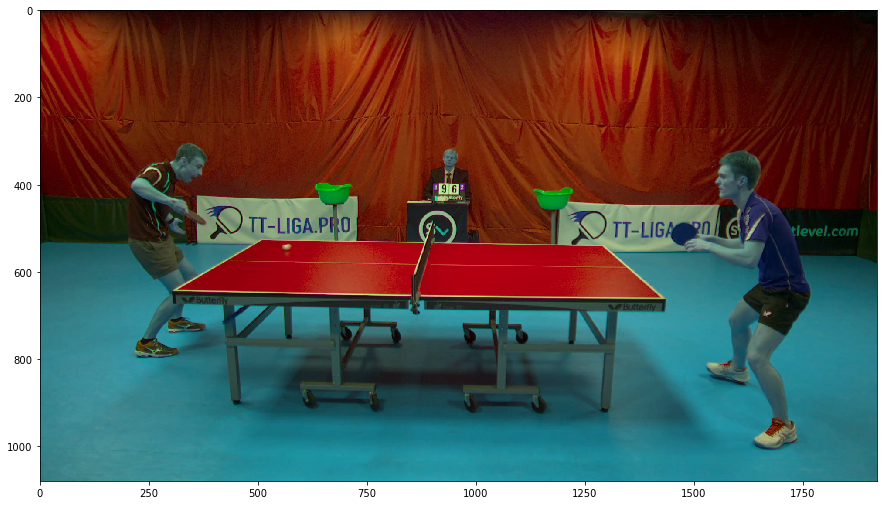

In [8]:
i += 1
print("Current frame: ", i)
tensor = torch.load('/scratch/vr1059/ttnet/game_1/train/{}.pt'.format(i))
plt.imshow(tensor.permute(1, 2, 0))

In [7]:
with open('/scratch/vr1059/ttnet/game_1/train/label_events.pkl', 'rb') as label:
    label_events = pkl.load(label)

In [8]:
label_events

{10: (0, 0),
 11: (0.38, 0),
 12: (0.7, 0),
 13: (0.92, 0),
 14: (1, 0),
 15: (0.92, 0),
 16: (0.7, 0),
 17: (0.38, 0),
 18: (0, 0),
 25: (0, 0),
 26: (0, 0.38),
 27: (0, 0.7),
 28: (0, 0.92),
 29: (0, 1),
 30: (0, 0.92),
 31: (0, 0.7),
 32: (0, 0.38),
 33: (0, 0),
 36: (0, 0),
 37: (0.38, 0),
 38: (0.7, 0),
 39: (0.92, 0),
 40: (1, 0),
 41: (0.92, 0),
 42: (0.7, 0),
 43: (0.38, 0),
 44: (0, 0),
 54: (0, 0),
 90: (0, 0),
 91: (0, 0.38),
 92: (0, 0.7),
 93: (0, 0.92),
 94: (0, 1),
 95: (0, 0.92),
 96: (0, 0.7),
 97: (0, 0.38),
 98: (0, 0),
 130: (0, 0),
 131: (0.38, 0),
 132: (0.7, 0),
 133: (0.92, 0),
 134: (1, 0),
 135: (0.92, 0),
 136: (0.7, 0),
 137: (0.38, 0),
 138: (0, 0),
 177: (0, 0),
 2181: (0, 0),
 2184: (0, 0),
 2185: (0.38, 0),
 2186: (0.7, 0),
 2187: (0.92, 0),
 2188: (1, 0),
 2189: (0.92, 0),
 2190: (0.7, 0),
 2191: (0.38, 0),
 2192: (0, 0),
 2203: (0, 0),
 2204: (0, 0.38),
 2205: (0, 0.7),
 2206: (0, 0.92),
 2207: (0, 1),
 2208: (0, 0.92),
 2209: (0, 0.7),
 2210: (0, 0.38

In [10]:
with open('/scratch/vr1059/ttnet/game_1/train/frame_ids.pkl', 'rb') as f:
    frame_ids = pickle.load(f)

In [11]:
with open('/scratch/vr1059/ttnet/game_1/ball_markup.json', 'rb') as f:
    ball_label = json.load(f)

In [12]:
for x in frame_ids:
    if str(x+8) not in ball_label:
        print(label_events[x])
        print(x+8)

In [2]:
train_ds = FrameDataset(phase='train', root_dir='/scratch/vr1059/ttnet/game_1/')
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True)

In [3]:
frames, event_label, ball_label, start, middle = iter(train_dl).next()

In [4]:
event_label

tensor([[0, 0],
        [0, 1]])

In [5]:
ball_label

tensor([[1274,  596],
        [ 793,  509]])

In [6]:
print(start, middle)

tensor([23192, 77660]) tensor([23196, 77664])


In [30]:
class ConvBlock(nn.Module):
    def __init__(self, a, b):
        super(ConvBlock, self).__init__()
        
        self.layers = [
            nn.Conv2d(a, b, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(b),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2)
        ]
        
        self.model = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.model(x)
        

class BallDetect(nn.Module):
    def __init__(self):
        super(BallDetect, self).__init__()
        
        self.encoder_list = [
            nn.Conv2d(3, 64, (1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
            nn.Dropout2d(),
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            nn.Dropout2d(),
            ConvBlock(128, 256),            
            ConvBlock(256, 256)
        ]
        
        self.fc_list = [
            nn.Dropout2d(),
            nn.Flatten(),
            nn.Linear(2560, 1792),
            nn.ReLU(),
            nn.Dropout(), 
        ]
        
        self.x_list = [
            nn.Linear(1792, 640),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(640, 320),
            nn.Sigmoid()
        ]
        
        self.y_list = [
            nn.Linear(1792, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, 128),
            nn.Sigmoid()
        ]
        
        self.encoder = nn.Sequential(*self.encoder_list)
        self.fc_branch = nn.Sequential(*self.fc_list)
        self.x = nn.Sequential(*self.x_list)
        self.y = nn.Sequential(*self.y_list)
        
    def forward(self, x):
        features = self.encoder(x)
        
        shared = self.fc_branch(features)
        
        x_coord = self.x(shared)
        y_coord = self.y(shared)
        
        return features, x_coord, y_coord

In [37]:
bd = BallDetect()
boom = torch.randn((1, 3, 320, 128))

In [38]:
a, b, c = bd(boom)
for x in [a, b, c]:
    print(x.shape)

torch.Size([1, 256, 5, 2])
torch.Size([1, 320])
torch.Size([1, 128])
